# Tracking EPA's COVID-19 non-enforcement policy
In late March 2020, EPA released a memo announcing that it would not penalize regulated industries that fail to meet their monitoring and reporting requirements due to COVID-19. Specifically EPA has said that it:

> "is not seeking penalties for noncompliance only in circumstances that involve routine monitoring and reporting requirements, if, on a case-by-case basis, EPA agrees that such noncompliance was caused by the COVID-19 pandemic."

This may have a number of public and environmental health impacts if facilities respond by increasing their emissions and discharges. See our response to EPA's memo here: https://envirodatagov.org/epas-covid-19-leniency-is-a-free-pass-to-pollute/

What is the effect of EPA's non-enforcement of Clean Air Act and Clean Water Act permits? Using this notebook, you can track how facilities' releases—as well as monitoring and reporting—of air and water hazards has changed in your state over the past few months, compared to previous years. 

Essentially, there are three scenarios we may see playing out:

_Monitoring and reporting violations_
- 1. Facilities that do not report (we can track this)....but do still meet their permit limits (yet we can't know this specifically, precisely because they didn't report)
- 2. Facilities that do *not* report (we can track this)....and actually exceed their limits (yet we can't know this specifically, precisely because they didn't report)

_Environmental violations_
- 3. Facilities that do meet their reporting obligations BUT they report having exceeded their permitted limits

Organization of this notebook:
 - Nationwide trends
     - Air emissions (from major sources?) (TBD)
     - Water discharges from major sources 
     - Water quality monitoring and reporting violations
 - Local trends: zoom in on a state/zip of interest
     - Air emissions (from major sources?) (TBD)
     - Water discharges from major sources (TBD)
     - Water quality monitoring and reporting violations (TBD)

---

## How to Run
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* **It is important to run cells in order because they depend on each other.**
* However, besides running the first cell below ("Setup"), you can run them section by section (e.g
* Some cells-especially in the "Select your state" section-will create a dropdown menu after you run them. Be sure to make a selection before running the next cell.
![Dropdown menu](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/dropdown.JPG?raw=true)
* Other cells will simply print information when you run them, like this one:
![Simple cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/cell-simple.JPG?raw=true)
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---

## Setup
Here we load some helper code to get us going.

In [47]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import csv
import datetime
import folium
import ipywidgets as widgets

#### Pick a month
We'll look at trends for that month across the past few decades of pollution trends

In [48]:
w=widgets.Dropdown(
    options=["01","02","03","04","05","06","07","08","09","10","11","12"],
    value = "03",
    description='Month:'
)
display(w)

Dropdown(description='Month:', index=2, options=('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '…

In [89]:
mnth=w.value

## National Trends

### Air emissions monitoring
First: Are facilities even doing stack tests? Stack tests involve measuring the volume of pollutants coming out of the facility's "smokestack".

The following cell will grab EPA data on facility stack tests for every April on record (up to 50 years ago). Some pollutant releases may be seasonal, so by looking only at Aprils, we can account for this variation and ensure an apples-to-apples comparison.

In [ ]:
sql = "select * from `ICIS-AIR_STACK_TESTS` where ACTUAL_END_DATE like '"+mnth+"/%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
data.set_index("pgm_sys_id", inplace=True)
data

#### Now we'll chart this data. 

The height of each bar will indicate how many tests there were, while the red line will show us the average number of these for all previous Aprils and the yellow line indicates the average for the past three years.

In [ ]:
data['ACTUAL_END_DATE'] = pd.to_datetime(data['ACTUAL_END_DATE'], format="%m/%d/%Y") #format

stacks = data.groupby(['ACTUAL_END_DATE'])['STATE_EPA_FLAG'].count() 
# = total number of pollutants stack test. May want to summarize by facility instead. 
stacks = stacks.resample('M').sum() #resample to a monthly basis  
stacks = stacks.loc[(stacks.index.month == int(mnth))] # Filter back to just Aprils
stacks = pd.DataFrame(stacks)
stacks = stacks.rename(columns={'STATE_EPA_FLAG': "Number of stack tests"})
stacks.index = stacks.index.strftime('%Y-%m') # makes the x axis (date) prettier

ax = stacks.plot(kind='bar', title = "Past Aprils—# of pollutants stack-tested", figsize=(20, 10), fontsize=16, color="#00C2AB")
ax

#label trendline
trend=stacks['Number of stack tests'].mean()
ax.axhline(y=trend, color='r', linestyle='-', label = "Long term average")

#label past 4 Aprils trend (2017, 2018, 2019, 2020)
trend_month=pd.concat([stacks.loc["2017-"+mnth],stacks.loc["2018-"+mnth],stacks.loc["2019-"+mnth]])
trend_month=trend_month['Number of stack tests'].mean()
ax.axhline(y=trend_month, color='y', linestyle='-', label = "Recent average")

### What are facilities releasing in to the air?
This has ramifications for COVID-19....

First, we'll get this data!

In [ ]:
sql = "select * from `ICIS-AIR_VIOLATION_HISTORY` where HPV_DAYZERO_DATE like '"+mnth+"-%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
data.set_index("pgm_sys_id", inplace=True)
data

#### Let's chart it!
The height of each bar will indicate how many emissions violations there have been, while the red line will show us the average number of these for all previous Aprils and the yellow line indicates the average for the past three years.

In [ ]:
data['HPV_DAYZERO_DATE'] = pd.to_datetime(data['HPV_DAYZERO_DATE'], format="%m-%d-%Y") #format

airviols = data.groupby(['HPV_DAYZERO_DATE'])['ENF_RESPONSE_POLICY_CODE'].count() 
# = total number of violations. May want to summarize by facility instead. 
airviols = airviols.resample('M').sum() #resample to a monthly basis  
airviols = airviols.loc[(airviols.index.month == int(mnth))] # Filter back to just Aprils
airviols = pd.DataFrame(airviols)
airviols = airviols.rename(columns={'ENF_RESPONSE_POLICY_CODE': "Number of violations"})
airviols.index = airviols.index.strftime('%Y-%m') # makes the x axis (date) prettier

ax = airviols.plot(kind='bar', title = "Past Aprils—# of Air Violations", figsize=(20, 10), fontsize=16)
ax

#label trendline
trend=airviols['Number of violations'].mean()
ax.axhline(y=trend, color='r', linestyle='-')

#label past 4 Aprils trend (2017, 2018, 2019, 2020)
trend_month=pd.concat([airviols.loc["2017-"+mnth],airviols.loc["2018-"+mnth],airviols.loc["2019-"+mnth]])
trend_month=trend_month['Number of violations'].mean()
ax.axhline(y=trend_month, color='y', linestyle='-')

Let's break it down by type of pollutant. We'll focus on two of what EPA calls "criteria pollutants" - those that have such an impact on human health, that the agency regulates how much of these can be in the atmosphere at any given time/place. The two are particulate matter, which is known to affect the circulatory and nervous systems, and sulfur dioxide, which exacerbates asthma.

In [ ]:
data['HPV_DAYZERO_DATE'] = pd.to_datetime(data['HPV_DAYZERO_DATE'], format="%m-%d-%Y") #format
cps = data

cps = cps[(cps['POLLUTANT_DESCS'].astype(str).str.contains('Particulate')) | (cps['POLLUTANT_DESCS'].astype(str).str.contains('Sulfur'))]
cps_map = cps # for mapping later...

cps = cps.groupby(['HPV_DAYZERO_DATE'])['POLLUTANT_DESCS'].count() 
# = total number of violations. May want to summarize by facility instead. 

cps = cps.resample('M').sum() #resample to a monthly basis  
cps = cps.loc[(cps.index.month == int(mnth))] # Filter back to just Aprils
cps = pd.DataFrame(cps)
cps = cps.rename(columns={'POLLUTANT_DESCS': "Number of violations"})
cps.index = cps.index.strftime('%Y-%m') # makes the x axis (date) prettier

ax = cps.plot(kind='bar', title = "Past Aprils—# of Violations Related to Particulate Matter and/or Sulfur Dioxide", figsize=(20, 10), fontsize=16)
ax

#label trendline
trend=cps['Number of violations'].mean()
ax.axhline(y=trend, color='r', linestyle='-')

#label past 4 Aprils trend (2017, 2018, 2019, 2020)
trend_month=pd.concat([cps.loc["2017-"+mnth],cps.loc["2018-"+mnth],cps.loc["2019-"+mnth]])
trend_month=trend_month['Number of violations'].mean()
ax.axhline(y=trend_month, color='y', linestyle='-')

#### *Where* are these facilities that exceeded their PM and SO2 permits last month?
Even if, on the whole, there are fewer exceedances, the places that are emitting more pollutants are important to track. Their neighbors are suffering more.

In [ ]:
latest = cps_map[(cps_map["HPV_DAYZERO_DATE"] >= '2020-'+mnth+'-01') & (cps_map["HPV_DAYZERO_DATE"] <= '2020-'+mnth+'-31')]

#latest = data[(data["HPV_DAYZERO_DATE"] >= '2020-04-01') & (data["HPV_DAYZERO_DATE"] < '2020-05-01')] # all violations, not just for PM/SO2
if (len(latest.index)>0):
    #get facility information from ECHO
    sql = "select FAC_NAME, AIR_IDS, FAC_LAT, FAC_LONG, FAC_PERCENT_MINORITY, CAA_QTRS_WITH_NC" + \
        " from ECHO_EXPORTER where AIR_FLAG = 'Y' "
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    echo_data.set_index( 'AIR_IDS', inplace=True ) # this is a cheap join and ignores where AIR_IDS maybe multiple...
    
    #merge echo and air data
    latest = latest.join(echo_data)
    
else:
    print("Actually, there were no reporting violations for April")

#### Make the map!
The map shows us all the facilities that report emitting more than their permitted levels of PM and SO2 in April 2020.

In [ ]:
# Filter to remove NaNs - missing data!
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))]

# Generate a scale by which we can classify facilities by quarters in non-compliance, and map them accordingly
latest["quartile"]=pd.qcut(latest["CAA_QTRS_WITH_NC"], 4, labels=False) # quartiles
radii={0:6, 1:10, 2:14, 3: 20}

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]]
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.CircleMarker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] + "\n Quarters in Non-Compliance over the past three years: "+str(row["CAA_QTRS_WITH_NC"]),
            radius = radii[row["quartile"]],
            color = "black",
            weight = 1,
            fill_color = "orange",
            fill_opacity= .4
        ).add_to(m)

    bounds = m.get_bounds()
    m.fit_bounds(bounds)

    # Show the map
    return m

map_of_facilities = mapper(latest)
map_of_facilities

#### What does this mean for environmental justice?
Define EJ. 

Are the facilities that violating air emissions permits in April in neighborhoods that are disproportionately non-white?

In [ ]:
## Chart FAC_PERCENT_MINORITY
# all facilities
ej = echo_data['FAC_PERCENT_MINORITY'].median()

# these facilities
l = latest['FAC_PERCENT_MINORITY'].median()

x = pd.DataFrame([{"All CAA Facilities": ej},{"CAA facilities in violation, April 2020":l}])

ax = x.plot(kind='bar', title = "Median percent minority population in a 3 mile radius of facilities", figsize=(20, 10), fontsize=16)
ax

### Water pollutant discharges

*NOTE*: Because there are so many facilities that discharge into waters of the US, there's a lot of data! The following cell may take a little while to run.

In [50]:
sql = "select NPDES_ID, EXCEEDENCE_PCT, MONITORING_PERIOD_END_DATE, PARAMETER_DESC" + \
    " from NPDES_EFF_VIOLATIONS where EXCEEDENCE_PCT > 0 and MONITORING_PERIOD_END_DATE like '"+mnth+"/%'"
#NPDES_ID like '" + my_state + "%' and" +\
#filter to facilities with pollutant exceedences

url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
data.set_index("NPDES_ID", inplace=True)
exceeds = data 
exceeds

,EXCEEDENCE_PCT,MONITORING_PERIOD_END_DATE,PARAMETER_DESC
NPDES_ID,,,
TX0023094,13,03/31/2006,"Solids, total suspended"
OH0111236,77,03/31/2004,"Solids, total suspended"
MA0110051,33,03/31/2000,"Flow, in conduit or thru treatment plant"
CA0037869,9,03/31/2005,"Coliform, fecal general"
IA0079138,537,03/31/2007,"Iron, total [as Fe]"
IL0050784,80,03/31/1995,"Chlorine, total residual"
IN0056855,299,03/31/2000,"BOD, 5-day, 20 deg. C"
TX0024261,187,03/31/2020,"Nitrogen, ammonia total [as N]"
IN0025224,4,03/31/2019,"Solids, total suspended"


#### Let's chart this
Are facilities exceeding their permits more this April than previous Aprils? Like with air emissions and monitoring, we need to compare April-April because there is a seasonality to many discharges.

The height of each bar will indicate how many pollution permits have been exceeded, while the red line will show us the average number of these for all previous Aprils and the yellow line indicates the average for the past three years.

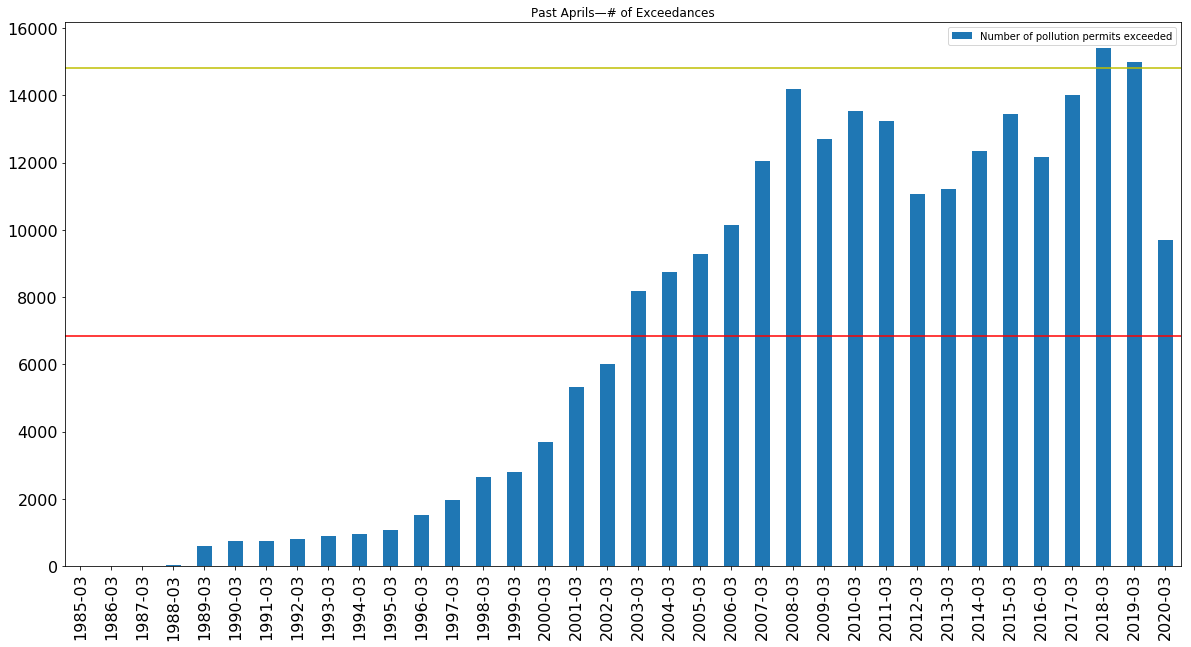

In [56]:
# First, let's look at the number of pollutant permits that were exceeded
exceeds['MONITORING_PERIOD_END_DATE'] = pd.to_datetime(exceeds['MONITORING_PERIOD_END_DATE'], format="%m/%d/%Y") #format

month = exceeds.groupby(['MONITORING_PERIOD_END_DATE'])['EXCEEDENCE_PCT'].count() # = total number of pollutants exceeded...# only need to keep one column. probably should rename...
month = month.resample('M').sum() #resample to a monthly basis and 
month = month.loc[(month.index.month == int(mnth))] # Filter back to just Aprils
month = pd.DataFrame(month)
month = month.rename(columns={'EXCEEDENCE_PCT': "Number of pollution permits exceeded"})
month.index = month.index.strftime('%Y-%m') # makes the x axis (date) prettier

ax = month.plot(kind='bar', title = "Past Aprils—# of Exceedances", figsize=(20, 10), fontsize=16)
ax

#label trendline
trend=month['Number of pollution permits exceeded'].mean()
ax.axhline(y=trend, color='r', linestyle='-')

#label past 4 Aprils trend (2017, 2018, 2019, 2020)
trend_month=pd.concat([month.loc["2017-"+mnth],month.loc["2018-"+mnth],month.loc["2019-"+mnth]])
trend_month=trend_month['Number of pollution permits exceeded'].mean()
ax.axhline(y=trend_month, color='y', linestyle='-')

In the next chart, the height of each bar will indicate how many *facilities* have exceeded their permits, while the red line will show us the average number of these for all previous Aprils and the yellow line indicates the average for the past three years.

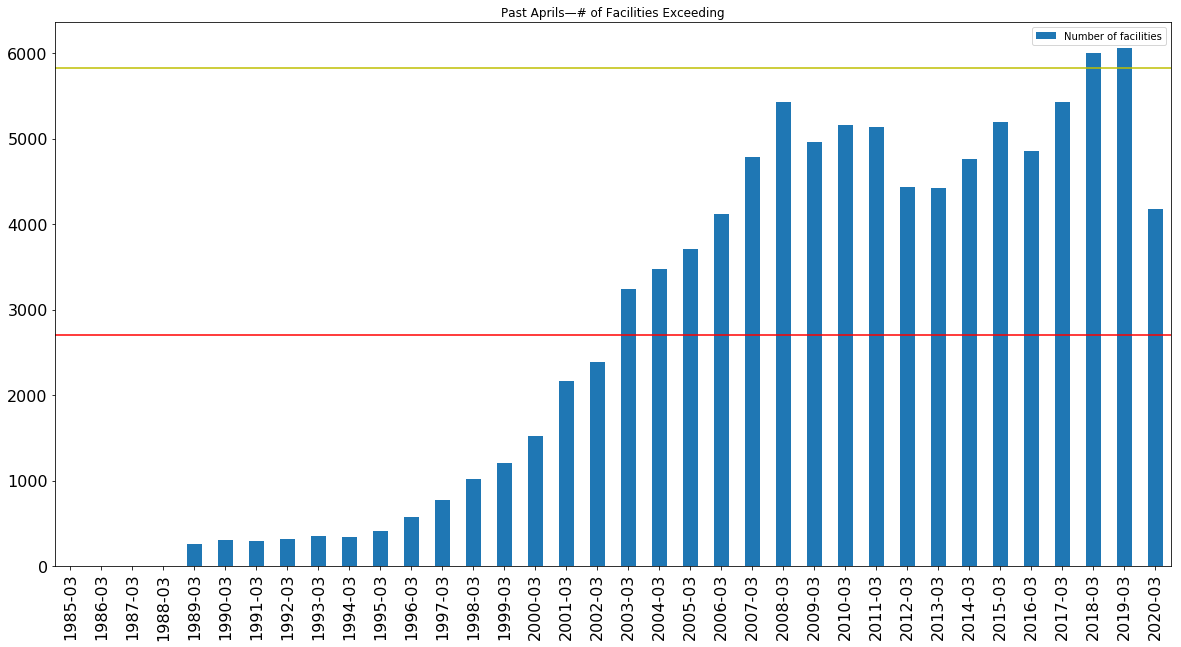

In [111]:
# Second, let's look at the number of facilities that exceeded their permits.
# Some facilities have multiple permits for multiple pollutants, so the results here may differ from those above

fac=exceeds.reset_index()
fac=fac.set_index(['MONITORING_PERIOD_END_DATE'])
facilities = fac.groupby(['MONITORING_PERIOD_END_DATE']).agg({"NPDES_ID": "nunique"})
facilities = facilities.resample('M').sum()
facilities = facilities.loc[(facilities.index.month == int(mnth))] # Filter back to just Aprils
facilities = facilities.rename(columns={'NPDES_ID': "Number of facilities"})
facilities.index = facilities.index.strftime('%Y-%m') # makes the x axis (date) prettier

ax = facilities.plot(kind='bar', title = "Past Aprils—# of Facilities Exceeding", figsize=(20, 10), fontsize=16)
ax

#label trendline
trend=facilities['Number of facilities'].mean()
ax.axhline(y=trend, color='r', linestyle='-')

#label past 4 Aprils trend (2017, 2018, 2019, 2020)
trend_month=pd.concat([facilities.loc["2017-"+mnth],facilities.loc["2018-"+mnth],facilities.loc["2019-"+mnth]])
trend_month=trend_month['Number of facilities'].mean()
ax.axhline(y=trend_month, color='y', linestyle='-')

The height of each bar will indicate *by how much* pollution permits tend to have been exceeded, while the red line will show us the typical exceedance for all previous Aprils and the yellow line indicates the trend for the past three years.

In [ ]:
# Third, let's look at how MUCH these facilities exceeded their permits.
# We'll calculate the median level (in percent terms) permits were exceeded by.

med = exceeds.reset_index()
med = med.set_index(['MONITORING_PERIOD_END_DATE'])
med = med.resample("M").median()
med = med.loc[(med.index.month == int(mnth))]
med = med.rename(columns={'EXCEEDENCE_PCT': "Median exceedance (% above permitted level)"})
med.index = med.index.strftime('%Y-%m') # makes the x axis (date) prettier

ax = med.plot(kind='bar', title = "Past Aprils—MEDIAN % EXCEEDANCE", figsize=(20, 10), fontsize=16)
ax

#label trendline
trend=med['Median exceedance (% above permitted level)'].mean()
ax.axhline(y=trend, color='r', linestyle='-')

#label past 4 Aprils trend (2017, 2018, 2019, 2020)
trend_month=pd.concat([med.loc["2017-"+mnth],med.loc["2018-"+mnth],med.loc["2019-"+mnth]])
trend_month=trend_month['Median exceedance (% above permitted level)'].mean()
ax.axhline(y=trend_month, color='y', linestyle='-')

#### Where are these facilities?

Let's look at their demographic profile

In [57]:
latest = exceeds[(exceeds['MONITORING_PERIOD_END_DATE'] >= '2020-'+mnth+'-01') & (exceeds['MONITORING_PERIOD_END_DATE'] <= '2020-'+mnth+'-31')] 
#print (latest)
if (len(latest.index)>0):
    #get facility information from ECHO
    sql = "select FAC_NAME, NPDES_IDS, FAC_LAT, FAC_LONG, FAC_PERCENT_MINORITY, CWA_QTRS_WITH_NC" + \
        " from ECHO_EXPORTER where NPDES_FLAG = 'Y' "
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    echo_data.set_index( 'NPDES_IDS', inplace=True )
    
    #merge echo and npdes data
    latest = latest.join(echo_data)
    print(latest)
    
else:
    print("Actually, there were no reporting violations for April")    

           EXCEEDENCE_PCT MONITORING_PERIOD_END_DATE  \
AK0046876              26                 2020-03-31   
AK0046876              87                 2020-03-31   
AK0046876              24                 2020-03-31   
AK0046876              93                 2020-03-31   
AK0053384             163                 2020-03-31   
AK0053384              23                 2020-03-31   
AK0053384               3                 2020-03-31   
AK0053384              43                 2020-03-31   
AK0053384            1367                 2020-03-31   
AK0053384              45                 2020-03-31   
AK0053384              83                 2020-03-31   
AK0053384              83                 2020-03-31   
AK0053384              22                 2020-03-31   
AK0053619               2                 2020-03-31   
AK0053686               3                 2020-03-31   
AKG380012             567                 2020-03-31   
AKG528110               1                 2020-0

In [ ]:
## Chart FAC_PERCENT_MINORITY
# all facilities
ej = echo_data['FAC_PERCENT_MINORITY'].median()

# these facilities
l = latest['FAC_PERCENT_MINORITY'].median()

x = pd.DataFrame([{"All CWA Facilities": ej},{"CWA facilities in violation, April 2020":l}])

ax = x.plot(kind='bar', title = "Median percent minority population in a 3 mile radius of facilities", figsize=(20, 10), fontsize=16)
ax

#### Finally, let's look at trends for just one pollutant, lead. 
Lead in our waters can have serious environmental and public health consequences.

In [ ]:
exceeds['MONITORING_PERIOD_END_DATE'] = pd.to_datetime(exceeds['MONITORING_PERIOD_END_DATE'], format="%m/%d/%Y") #format

lead = exceeds[(exceeds['PARAMETER_DESC'].astype(str).str.contains('Lead'))]

lead = lead.groupby(['MONITORING_PERIOD_END_DATE'])['PARAMETER_DESC'].count() # = total number of pollutants exceeded...# only need to keep one column. probably should rename...
lead = lead.resample('M').sum() #resample to a leadly basis and 
lead = lead.loc[(lead.index.month == int(mnth))] # Filter back to just Aprils
lead = pd.DataFrame(lead)
lead = lead.rename(columns={'PARAMETER_DESC': "Number of pollution permits exceeded"})
lead.index = lead.index.strftime('%Y-%m') # makes the x axis (date) prettier

ax = lead.plot(kind='bar', title = "Past Aprils—# of times permits to discharge lead were exceeded", figsize=(20, 10), fontsize=16)
ax

#label trendline
trend=lead['Number of pollution permits exceeded'].mean()
ax.axhline(y=trend, color='r', linestyle='-')

#label past 4 Aprils trend (2017, 2018, 2019, 2020)
trend_lead=pd.concat([lead.loc["2017-"+mnth],lead.loc["2018-"+mnth],lead.loc["2019-"+mnth]])
trend_lead=trend_lead['Number of pollution permits exceeded'].mean()
ax.axhline(y=trend_lead, color='y', linestyle='-')

### Water Quality Monitoring and Reporting
First, we'll look at how facilities regulated under the Clean Water Act have altered their required monitoring practices.

Run the code in the cell below, which will query our copy of the ECHO database and pull information on regulated facilities in your state.

Specifically, we'll find records of facilities out of compliance - that is, violating their permits - due to "Non-Receipt of DMR/Schedule Report" DMR stands for Discharge Monitoring Reports, and are required by the CWA's National Pollutant Discharge Elimination System (NPDES). 

Not submitting these reports on schedule can lead to "Reportable Non-Compliance" with NPDES and CWA. According to the EPA, "DMR values not received within 31 days of the DMR form due date result in the generation of a violation code (D80 or D90). ICIS-NPDES identifies these DMR non-receipt violations and automatically creates violation codes for the missing DMR values with monitoring requirements (D80) and missing DMR values with effluent limits (D90). EPA's data sharing policy allows states a 40-day window to report DMR values to EPA's data system; therefore, DMR values reported on time to state agencies and shared with EPA within 40 days do not contribute to permit level noncompliance status."

In this case, "N" does NOT mean no - it just is a code for the kind of violation event we're interested in (non-reporting).

In [90]:
sql = "select NPDES_ID, SCHEDULE_DATE, RNC_DETECTION_CODE, SCHEDULE_EVENT_DESC" + \
    " from NPDES_PS_VIOLATIONS where RNC_DETECTION_CODE = 'N' and " + \
    " SCHEDULE_DATE like '"+mnth+"/%'"
#" NPDES_ID like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
data.set_index("NPDES_ID", inplace=True)
data

,SCHEDULE_DATE,RNC_DETECTION_CODE,SCHEDULE_EVENT_DESC
NPDES_ID,,,
PR0023990,03/01/1995,N,Solids Handling Plan
IN0040835,03/01/1999,N,Status/Progress Report
IN0031909,03/01/2001,N,Status/Progress Report
PR0025666,03/01/1996,N,Toxics Report
PR0025666,03/28/1996,N,Toxics Report
IN0031500,03/01/2000,N,Status/Progress Report
MA0100978,03/15/2001,N,TRC Evaluation Report
PR0023752,03/01/1995,N,Analytical Methods Report
MA0100421,03/01/2003,N,Inflow/Infiltration Report


### Let's organize this information by date
We're curious to track whether non-receipt of DMRs has increased due to COVID, so we have to be able to summarize and order facilities' violations across time.

In [91]:
# The NPDES_IDS in ECHO_EXPORTER can contain multiple ids for a facility. 
data['SCHEDULE_DATE'] = pd.to_datetime(data['SCHEDULE_DATE'], format="%m/%d/%Y")
by_date = data.groupby('SCHEDULE_DATE')[['RNC_DETECTION_CODE']].count()
by_date=by_date.resample('M').sum()
by_date = by_date.loc[(by_date.index.month == int(mnth))] # Filter back to just the selected month
by_date

,RNC_DETECTION_CODE
SCHEDULE_DATE,
1978-03-31,3
1979-03-31,0
1980-03-31,0
1981-03-31,3
1982-03-31,1
1983-03-31,0
1984-03-31,0
1985-03-31,0
1986-03-31,3


### Plot this ^ !!!
It's all well and good to have this table, but it's hard to pick out patterns from tabular data. Let's plot it as what's called a histogram in order to see what's going on.

The height of each bar will indicate how many facilities were out of compliance due to missing or late reports, while the red line will show us the average number of these facilities for all previous Aprils and the yellow line indicates the average for the past three years or so.

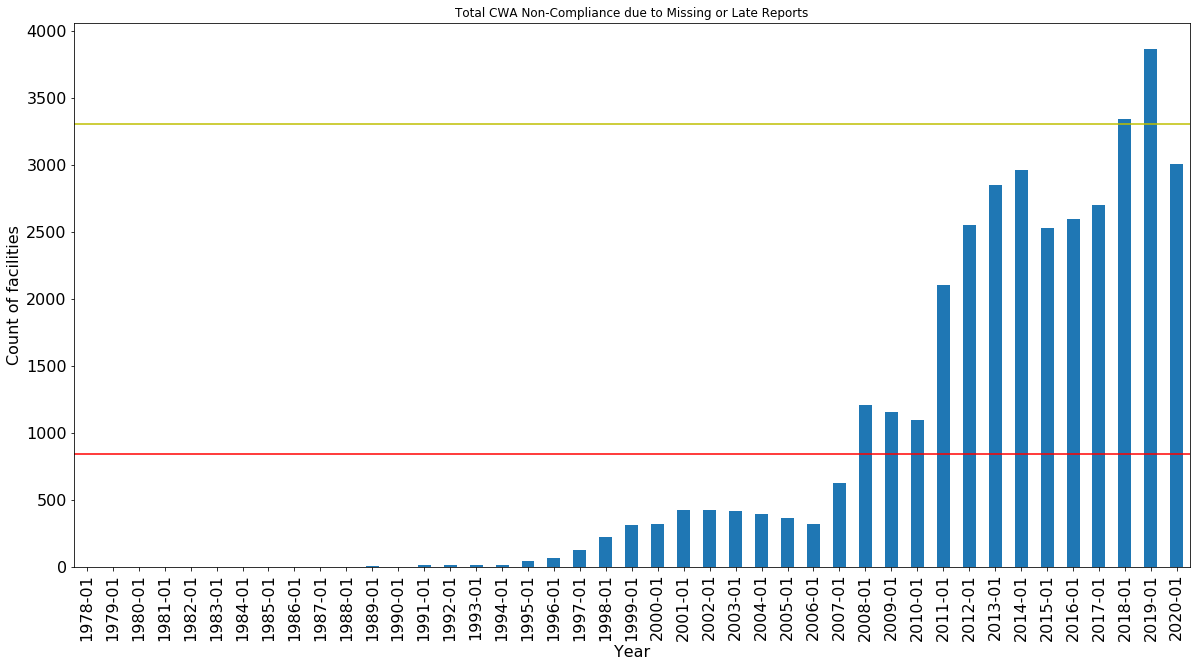

In [87]:
by_date.index = by_date.index.strftime('%Y-%m') # makes the x axis (date) prettier

chart_title = "Total CWA Non-Compliance due to Missing or Late Reports"
ax = by_date.plot(kind='bar', title = chart_title, figsize=(20, 10), legend=False, fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Count of facilities", fontsize=16)

#label trendline
trend=by_date['RNC_DETECTION_CODE'].mean()
ax.axhline(y=trend, color='r', linestyle='-')

#label past 4 Aprils trend (2017, 2018, 2019, 2020)
trend_month=pd.concat([by_date.loc["2017-"+mnth],by_date.loc["2018-"+mnth],by_date.loc["2019-"+mnth]])
trend_month=trend_month['RNC_DETECTION_CODE'].mean()
ax.axhline(y=trend_month, color='y', linestyle='-')

#### What kind of reports aren't being submitted?

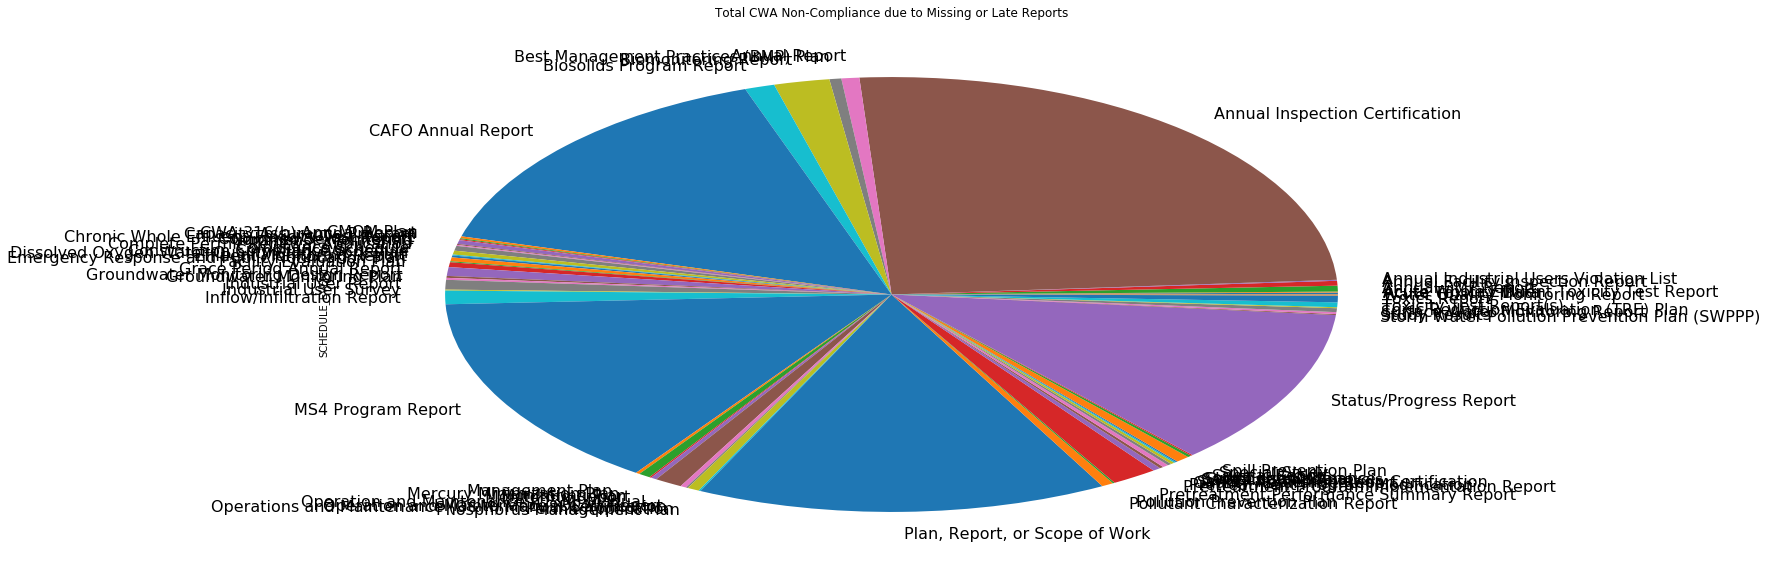

In [92]:
pie = data[(data['SCHEDULE_DATE'] >= '2020-'+mnth+'-01') & (data['SCHEDULE_DATE'] <= '2020-'+mnth+'-31')].sort_index()
pie = pie.groupby('SCHEDULE_EVENT_DESC')[['SCHEDULE_EVENT_DESC']].count()
ax = pie.plot(kind='pie', y='SCHEDULE_EVENT_DESC', title = chart_title, figsize=(20, 10), legend=False, fontsize=16)
ax

### Are there facilities that reported exceedences for some pollutants but also didn't report on others?
This could give us a sense of how likely it is that non-reported discharges violated permit levels

In [110]:
# this month non reporters = data
# this month permit exceeders = latest
pe = latest.sort_index()
nr = data[(data['SCHEDULE_DATE'] >= '2020-'+mnth+'-01') & (data['SCHEDULE_DATE'] <= '2020-'+mnth+'-31')].sort_index() 

#group by facility
pe=pe.groupby(pe.index)[["EXCEEDENCE_PCT"]].count() #number of permits exceeded
nr=nr.groupby(nr.index)[["RNC_DETECTION_CODE"]].count() #number of reports missing

# now find where the IDs match
test=pe.join(nr)
#pe.loc[pe.index=='AK0053775']
test=test.loc[(test['RNC_DETECTION_CODE']>0)]
test
48/4177

0.011491501077328227

### Which facilities didn't report this month?
This will give us a good indicator of the impact of EPA's memo, which went into effect that month.

First, let's get more information about those facilities.

In [ ]:
latest = data[(data["SCHEDULE_DATE"] >= '2020-'+mnth+'-01') & (data["SCHEDULE_DATE"] <= '2020-'+mnth+'-31')] 

if (len(latest.index)>0):
    #get facility information from ECHO
    sql = "select FAC_NAME, NPDES_IDS, FAC_LAT, FAC_LONG, CWA_QTRS_WITH_NC, FAC_PERCENT_MINORITY" + \
        " from ECHO_EXPORTER where NPDES_FLAG = 'Y' "
    url='http://apps.tlt.stonybrook.edu/echoepa/?query='
    data_location=url+urllib.parse.quote(sql)
    echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
    echo_data.set_index( 'NPDES_IDS', inplace=True )
    
    #merge echo and npdes data
    latest = latest.join(echo_data)
    print(latest)
    
else:
    print("Actually, there were no reporting violations for April")    

### Map them!
Now we'll map those facilities. The ones that have spent more quarters in non-compliance over the past three years will be displayed as larger.

In [ ]:
# Filter to remove NaNs - missing data!
latest = latest[~(np.isnan(latest["FAC_LAT"])) | ~(np.isnan(latest["FAC_LONG"]))]

# Generate a scale by which we can classify facilities by quarters in non-compliance, and map them accordingly
latest["quartile"]=pd.qcut(latest["CWA_QTRS_WITH_NC"], 4, labels=False, duplicates="drop") # quartiles
#latest.merge(scale)
#print(latest)
radii={0:6, 1:10, 2:14, 3: 20}

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 8
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        #print(index,row)
        folium.CircleMarker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] + "\n Quarters in Non-Compliance over the past three years: "+str(row["CWA_QTRS_WITH_NC"]),
            radius = radii[row["quartile"]],
            color = "black",
            weight = 1,
            fill_color = "orange",
            fill_opacity= .4
        ).add_to(m)

    bounds = m.get_bounds()
    m.fit_bounds(bounds)

    # Show the map
    return m

map_of_facilities = mapper(latest)
map_of_facilities

In [ ]:
## Chart FAC_PERCENT_MINORITY
# all facilities
ej = echo_data['FAC_PERCENT_MINORITY'].median()

# these facilities
l = latest['FAC_PERCENT_MINORITY'].median()

x = pd.DataFrame([{"All CWA Facilities": ej},{"CWA facilities in violation of reporting requirements, April 2020":l}])

ax = x.plot(kind='bar', title = "Median percent minority population in a 3 mile radius of facilities", figsize=(20, 10), fontsize=16)
ax

---
## Select your state
Let's dissect the patterns above by looking at a specific state...
Go to this notebook here: XXXXXXXXXX